In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread

from skimage.util import img_as_float
from skimage.color import gray2rgb

import tifffile
import napari
import zarr
import dask.array as da

In [2]:
sample = '840001_0152'

In [3]:
def single_channel_pyramid(tiff_path, channel):

    target_filepath = tiff_path
    tiff = tifffile.TiffFile(target_filepath, is_ome=False)

    pyramid = [
        zarr.open(s[channel].aszarr())
        for s in tiff.series[0].levels
        ]

    pyramid = [
        da.from_zarr(z)
        for z in pyramid
        ]

    return pyramid

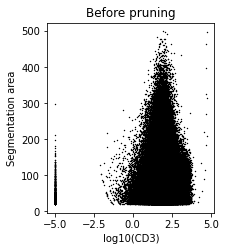

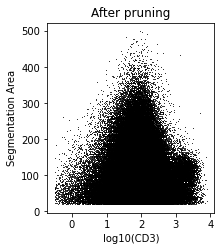

In [4]:
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/outliers'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# read TOPACIO single-cell data BEFORE pruning outliers
data = pd.read_parquet(
    '/Users/greg/Dropbox (HMS)/topacio/cylinter_output/TOPACIO_FINAL/output_orig/'
    'checkpoints/selectROIs.parquet'
    )
data = data[data['Sample'] == sample].copy()

# isolate immunomarker channels
markers = pd.read_csv('/Volumes/My Book/cylinter_input/topacio/markers.csv')
exclude = ['antiRat', 'antiRabbit', 'antiGoat', 'pSTAT1', 'Ki67', 'STING', 'pTBK1', 'pSTAT3', 'PCNA', 'HLAA', 'cPARP']
include = [i for i in data.columns if 'DNA' not in i if i not in exclude if i in list(markers['marker_name'])]

# log-transform antibody expression data
transformed_data = np.log10(data[include] + 0.00001)
data.update(transformed_data)

channel = 'CD3'
channel_number = 5

data = data[data['Area'] < 500]

fig, ax = plt.subplots(figsize=(3,3.5))
ax.scatter(data[channel], data['Area'], color='k', ec='w', lw=0.0, s=2.0, alpha=1.0)
plt.title(f'Before pruning')
plt.xlabel(f'log10({channel})')
plt.ylabel('Segmentation area')
plt.savefig(os.path.join(save_dir, 'before_pruning.png'), dpi=1000)
plt.savefig(os.path.join(save_dir, 'before_pruning.pdf'))
plt.show()
plt.close('all')

# prune data
data_gated = data[(data[channel] > -0.5) & (data[channel] < 3.9)]

gate = 2.9

top = data_gated[(data_gated[channel] > gate) & (data_gated['Area'] > 70.0)]
top_centroids = top[['Y_centroid', 'X_centroid']]

bottom = data_gated[(data_gated[channel] > gate) & (data_gated['Area'] <= 70.0)]
bottom_centroids = bottom[['Y_centroid', 'X_centroid']]

other = data_gated[data_gated[channel] <= gate]
other_centroids = other[['Y_centroid', 'X_centroid']]

fig, ax = plt.subplots(figsize=(3,3.5))
for c, d in zip(['k', 'k', 'k'], [other, top, bottom]):
    ax.scatter(d[channel], d['Area'], color=c, ec='w', lw=0.0, s=1.0, alpha=1.0)
# ax.axvline(gate, c='tab:red', lw=3.0)
plt.title(f'After pruning')
plt.xlabel(f'log10({channel})')
plt.ylabel('Segmentation Area')
plt.savefig(os.path.join(save_dir, 'after_pruning.png'), dpi=1000)
plt.savefig(os.path.join(save_dir, 'after_pruning.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


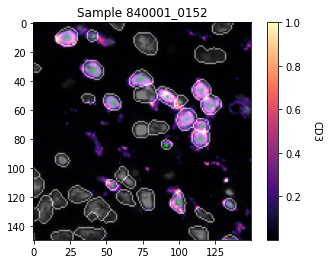

In [5]:
img_path = (f'/Volumes/My Book/cylinter_input/TOPACIO_FINAL/tif/{sample}.ome.tif')
seg_path = (f'/Volumes/My Book/cylinter_input/TOPACIO_FINAL/seg/{sample}.ome.tif')

dna = single_channel_pyramid(img_path, channel=0)
seg = single_channel_pyramid(seg_path, channel=0)
cd8a = single_channel_pyramid(img_path, channel=13)

# view images in Napari
# viewer = napari.view_image(dna, opacity=0.5, rgb=False, name='DNA1')

# viewer.add_image(
#     seg, rgb=False, blending='opaque', opacity=0.2,
#     colormap='gray', visible=False, name='segmentation'
#     )

# viewer.add_image(
#     cd8a, rgb=False, blending='additive',
#     colormap='bop blue', visible=True, name='CD8a'
#     )

# viewer.add_points(
#     cd8_top_centroids, name='CD8T_top',
#     face_color='lime',  # #ffaa00
#     edge_width=0.0, size=5.0)

# viewer.add_points(
#     cd8_bottom_centroids, name='CD8T_bottom',
#     face_color='red',
#     edge_width=0.0, size=5.0)


# viewer.add_points(
#     other_centroids, name='other',
#     face_color='gainsboro',
#     edge_width=0.0, size=5.0)

# viewer.layers['CD8a'].contrast_limits = (0, 8000)

# napari.run()

# crop image
ymin = 15475
ymax = 15625
xmin = 10058
xmax = 10208

img = imread(img_path, key=0)
dna_crop = img[ymin:ymax, xmin:xmax]
dna_crop = img_as_float(dna_crop)
dna_crop = (dna_crop - np.min(dna_crop)) / (np.max(dna_crop) - np.min(dna_crop))  # normalize 0-1
dna_crop_rgb = gray2rgb(dna_crop)
dna_crop_rgb *= 0.5

img = imread(img_path, key=channel_number)
crop = img[ymin:ymax, xmin:xmax]
crop = img_as_float(crop)
crop = (crop - np.min(crop)) / (np.max(crop) - np.min(crop))  # normalize 0-1
crop = np.clip(crop, 0.05, 0.7)
crop = (crop - np.min(crop)) / (np.max(crop) - np.min(crop))  # normalize 0-1
crop_rgb = plt.cm.magma(crop) # converts to RGBA automatically
crop_rgb = crop_rgb[:, :, 0:3]  # drop alpha dimension

img = imread(seg_path, key=0)
seg_crop = img[ymin:ymax, xmin:xmax]
seg_crop = img_as_float(seg_crop)
seg_crop = (seg_crop - np.min(seg_crop)) / (np.max(seg_crop) - np.min(seg_crop))  # normalize 0-1
seg_crop_rgb = gray2rgb(seg_crop)
seg_crop_rgb *= 0.5

blank = np.zeros((dna_crop.shape[0], dna_crop.shape[1]))
blank = gray2rgb(blank)

blank += dna_crop_rgb
blank += crop_rgb
blank += seg_crop_rgb

plt.imshow(blank, cmap='magma')

cbar = plt.colorbar()
# cbar = plt.colorbar(format=ticker.FuncFormatter(fmt))
cbar.set_alpha(1.0)
cbar.set_label(channel, labelpad=20, rotation=270)
cbar.draw_all()

# isolate data for cells within crop bounds
top_crop = top[['Y_centroid', 'X_centroid', 'DNA1']][
    (top['X_centroid'].between(xmin, xmax, inclusive='both')) &
    (top['Y_centroid'].between(ymin, ymax, inclusive='both'))
    ]

# transform x, y coordinates of cells within ROI bounds
top_crop['X_centroid'] = top_crop['X_centroid']-xmin
top_crop['Y_centroid'] = top_crop['Y_centroid']-ymin

plt.scatter(
    top_crop['X_centroid'],
    top_crop['Y_centroid'],
    s=6.5, lw=0.0, color='lime'
    )

# isolate data for cells within crop bounds
bottom_crop = bottom[['Y_centroid', 'X_centroid', 'DNA1']][
    (bottom['X_centroid'].between(xmin, xmax, inclusive='both')) &
    (bottom['Y_centroid'].between(ymin, ymax, inclusive='both'))
    ]

# transform x, y coordinates of cells within ROI bounds
bottom_crop['X_centroid'] = bottom_crop['X_centroid']-xmin
bottom_crop['Y_centroid'] = bottom_crop['Y_centroid']-ymin

# overlay cell centroids
plt.scatter(
    bottom_crop['X_centroid'],
    bottom_crop['Y_centroid'],
    s=6.5, lw=0.0, color='lime'
    )

# isolate data for cells within crop bounds
other_crop = other[['Y_centroid', 'X_centroid', 'DNA1']][
    (other['X_centroid'].between(xmin, xmax, inclusive='both')) &
    (other['Y_centroid'].between(ymin, ymax, inclusive='both'))
    ]

# transform x, y coordinates of cells within ROI bounds
# other_crop['X_centroid'] = other_crop['X_centroid']-xmin
# other_crop['Y_centroid'] = other_crop['Y_centroid']-ymin

# overlay cell centroids
# plt.scatter(
#     other_crop['X_centroid'],
#     other_crop['Y_centroid'],
#     s=6.5, lw=0.0, color='lime'
#     )

plt.title(f'Sample {sample}')
plt.savefig(os.path.join(save_dir, 'image.png'), dpi=1000)
plt.savefig(os.path.join(save_dir, 'image.pdf'))
plt.show()